# **Reinforcement Learning Project**
# Deep reinforcement learning for energy management systems in a microgrid
---
---

This notebook has 4 parts. The goals of these parts are:
- **Part 1**:
- **Part 2**:
- **Part 3**:
- **Part 4**:

### Installing Dependencies

Microgrids – self-contained electrical grids that are capable of disconnecting from the main grid – hold potential in both tackling climate change mitigation via reducing CO
 emissions and adaptation by increasing infrastructure resiliency. Due to their distributed nature, microgrids are often idiosyncratic; as a result, control of these systems is nontrivial.

 While microgrid simulators exist, many are limited in scope and in the variety of microgrids they can simulate. We propose pymgrid, an open-source Python package to generate and simulate a large number of microgrids, and the first open-source tool that can generate more than 600 different microgrids. pymgrid abstracts most of the domain expertise, allowing users to focus on control algorithms.

 In particular, pymgrid is built to be a reinforcement learning (RL) platform, and includes the ability to model microgrids as Markov decision processes
 pymgrid also introduces two pre-computed list of microgrids, intended to allow for research reproducibility in the microgrid setting.

In [ ]:
import zipfile
import io

# Specify the name of the uploaded zip file
zip_file_name = 'data.zip'

# Extract the contents
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')

### Env : Smart Home


### Constants

In [ ]:
#Constant that indicates which actions is taken
class Actions:
	NO_ACTION = 0
	CHARGE_HOME_wPV = 1         #Charging Home with Photovoltaic
	CHARGE_HOME_wSG = 2         #Charging Home with SmartGrid

	CHARGE_EV_wPV = 3           #Charging EV with Photovoltaic
	CHARGE_EV_wSG = 4           #Charging EV with SmartGrid

class Specifications:
	HOME_CAPACITY = 100
	EV_CAPACITY = 100
	EV_DAILY_CONSUME = 11
	EV_CHARGE_WINDOW = [18, 6]      #Charging when the EV is at home and not use
	MAX_CHARGE_FOR_HOUR = 11

class Constant:
	MONTHS_LEN = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
	MAX_STEP_HOURS = 24 * 30


### Class to preprocess PV entry, SG prices and H4 consumes

In [ ]:
class ProcessedData:
	def __init__(self):
		self.PV_production = []                       #Production of Photovoltaic
		self.SG_prices = []                           #Price of SmartGrid Electricity
		self.H4_consumes = []                         #The consumption/need of the home

	# Methods to add the elements in the specific arrays
	def add_PV_entry(self, el): self.PV_production.append( el )
	def add_SG_prices(self, el): self.SG_prices.append( el )
	def add_H4_consumes(self, el): self.H4_consumes.append( el )

	# Get Methods (given month and time return the value)
  # To get the element it converts every day in hours
	def get_PV_entry(self, month, day, day_time): return self.PV_production[ (sum(Constant.MONTHS_LEN[:month-1]) + day - 1) * 24  + day_time ]
	def get_SG_prices(self, month, day, day_time): return self.SG_prices[ (sum(Constant.MONTHS_LEN[:month-1]) + day - 1) * 24  + day_time ]
	def get_H4_consumes(self, month, day, day_time): return self.H4_consumes[ (sum(Constant.MONTHS_LEN[:month-1]) + day - 1) * 24  + day_time ]

### Function for plotting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

class LinePlotter:

	def __init__(self, x_label="X Label", y_label="Y Label", title="No Title"):
		self.fig, self.ax = plt.subplots(1)
		self.ax.spines["top"].set_visible(False)
		self.ax.spines["bottom"].set_visible(False)
		self.ax.spines["right"].set_visible(False)
		self.ax.spines["left"].set_visible(False)
		self.ax.set_facecolor('#eaeaf2')
		plt.grid(color='#ffffff', linestyle='-', linewidth=1)
		plt.xticks(fontsize=12)
		plt.yticks(fontsize=12)
		plt.xlabel(x_label, fontsize=12)
		plt.ylabel(y_label, fontsize=12)
		plt.title(title, fontsize=16)
		self.data_arrays = []
		self.array_len = -1
		self.mean_array = []
		self.var_array =  []
		self.max_array = []
		self.min_array = []

	def load_array(self, file_name_arrays, early_stop=None):
		data_arrays = [[np.loadtxt(name, delimiter='\n', unpack=True) for name in array_set] for array_set in file_name_arrays]
		if(early_stop == None): self.array_len = min([min([len(el) for el in array_set]) for array_set in data_arrays])
		else: self.array_len = early_stop
		self.data_arrays = np.array([[el[:self.array_len] for el in array_set] for array_set in data_arrays], dtype=object)

	def render(self, labels, colors):
		err_msg = "load some data before the render!"
		assert self.array_len > 0, err_msg
		for mean_values, max_values, min_values, label, color in zip(self.mean_array, self.max_array, self.min_array, labels, colors):
			self.ax.plot(self.x_axes, mean_values, label=label, color=color, linestyle='-', linewidth=1.2 )
			self.ax.fill_between(self.x_axes, max_values, min_values, facecolor=color, alpha=0.3)
		self.ax.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=14)
		plt.show()

	def process_data(self, rolling_window=1, starting_pointer=0, early_stop=None):
		rolling_queue = deque(maxlen=rolling_window)
		self.x_axes = [i for i in range(self.array_len-starting_pointer)]
		for array_set in self.data_arrays:
			for array in array_set:
				for i in range(self.array_len):
					rolling_queue.append(array[i])
					array[i] = np.mean(rolling_queue)
				rolling_queue.clear()
		# Fix for different array size
		self.data_arrays = np.array([np.array(el) for el in self.data_arrays], dtype=object)
		self.mean_array = np.array([[np.mean(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays])
		self.var_array =  np.array([[np.std(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays])
		self.max_array = [[np.max(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays]
		self.min_array = [[np.min(array_set[:, i]) for i in range(self.array_len)][starting_pointer:] for array_set in self.data_arrays]


class HistoPlotter():

	def __init__(self):
		self.trained_list = []
		self.random_list = []

	def plot( self ):
		fig = plt.figure()
		ax = fig.add_subplot(111)
		N = len(self.trained_list)
		ind = np.arange(N)
		width = 0.35
		rects1 = ax.bar(ind, self.trained_list, width,
						color='black',
						error_kw=dict(elinewidth=2,ecolor='Red'))
		rects2 = ax.bar(ind+width, self.random_list, width,
							color='red',
							error_kw=dict(elinewidth=2,ecolor='Blue'))
		ax.set_xlim(-width,len(ind)+width)
		ax.set_ylabel('Money Spent (euros)', fontsize=12)
		ax.set_title('Smart Home')
		xTickMarks = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
		ax.set_xticks(ind+width)
		xtickNames = ax.set_xticklabels(xTickMarks)
		plt.setp(xtickNames, rotation=45, fontsize=12)
		ax.legend( (rects1[0], rects2[0]), (f"Trained Network (total={sum(self.trained_list):6.2f})", f"Random Actions (total={sum(self.random_list):6.2f})"), fontsize=14 )
		plt.show()


class DoubleLinePlotter():

	def __init__(self, battery_level=[10, 20, 30], ev_level= [0, 0, 0], price=[30, 20, 10], hourly_charge_sg=[0, 0, 0], hourly_charge_pv=[0, 0, 0] ):
		self.battery_level = battery_level
		self.ev_level = ev_level
		self.charge_sg = hourly_charge_sg
		self.charge_pv = hourly_charge_pv
		self.price = price

	def plot( self ):
		fig, ax = plt.subplots()
		axes = [ax, ax.twinx()]
		fig.subplots_adjust(right=0.86)
		ax.set_xlabel('Time (h)')

		# Plot on Axis 1: Battery consupmtion
		X = [str(i) for i in range(24)]
		axes[0].bar(X, self.charge_sg, color='green', label="from SG")
		axes[0].bar(X, self.charge_pv, color='blue', label="from PV")
		axes[0].set_ylabel("Charge (kWh)", color='black')
		axes[0].tick_params(axis='y', colors='black')
		axes[0].legend(loc='upper right', fontsize=14)

		# Plot on Axis 2: Price
		axes[1].plot(self.price, linestyle='-', color='red', linewidth=1.2)
		axes[1].set_ylabel('Price (kWh)', color='red')
		axes[1].tick_params(axis='y', colors='red')

		# Final Plot
		plt.show()


class GenerationPlotter():

	def __init__(self, pv, grid, battery_charge):
		self.pv = pv
		self.grid = grid
		self.battery_charge = battery_charge

	def plot( self ):
		fig, ax = plt.subplots()
		axes = [ax, ax.twinx()]
		fig.subplots_adjust(right=0.86)
		ax.set_xlabel('Time (h)')

		# Plot on Axis 1: Battery consupmtion
		X = [str(i) for i in range(24)]
		axes[0].bar(X, self.battery_charge, color='blue', label="Battery Discharge")
		axes[0].bar(X, self.pv, color='red', label="PV")
		axes[0].bar(X, self.grid, color='green', label="Grid")
		axes[0].set_ylabel("Energy (kWh)", color='black')
		axes[0].tick_params(axis='y', colors='black')
		axes[0].legend(loc='upper right', fontsize=14)

		# Plot on Axis 2: Price
		#axes[1].plot(self.price, linestyle='-', color='red', linewidth=1.2)
		#axes[1].set_ylabel('Price (kWh)', color='red')
		#axes[1].tick_params(axis='y', colors='red')

		# Final Plot
		plt.show()

class DemandsPlotter():

	def __init__(self, house_demands, battery_charge):
		self.house_demands = house_demands
		self.battery_charge = battery_charge

	def plot( self ):
		fig, ax = plt.subplots()
		axes = [ax, ax.twinx()]
		fig.subplots_adjust(right=0.86)
		ax.set_xlabel('Time (h)')

		# Plot on Axis 1: Battery consupmtion
		X = [str(i) for i in range(24)]
		axes[0].bar(X, self.battery_charge, color='green', label="Battery Charge")
		axes[0].bar(X, self.house_demands, color='blue', label="House Demands")
		axes[0].set_ylabel("Energy (kWh)", color='black')
		axes[0].tick_params(axis='y', colors='black')
		axes[0].legend(loc='upper right', fontsize=14)

		# Plot on Axis 2: Price
		#axes[1].plot(self.price, linestyle='-', color='red', linewidth=1.2)
		#axes[1].set_ylabel('Price (kWh)', color='red')
		#axes[1].tick_params(axis='y', colors='red')

		# Final Plot
		plt.show()

### Env : Smart Home

In [ ]:
from gym import spaces, logger
from gym.utils import seeding
import pandas as pd
import numpy as np

class SmartHome:

	def __init__(self):
		# Initial battery state
		self.home_battery_state = 0
		self.ev_battery_state = 0

		# Initial date and time
		self.month = 1
		self.day = 1
		self.time = 0

		# Initial episode length
		self.max_step_hours = 0

		# Load the data tables and data processing in the ProcessedData class
		self.processed_data = ProcessedData()
		self.__load_data_tables()

		# Define gym actions and env
		self.action_space = spaces.Discrete(5)     													#Discret space of action
		low = np.array([0 for _ in range(5)], dtype=np.float64)
		high = np.array([1 for _ in range(5)], dtype=np.float64)
		self.observation_space = spaces.Box(low, high, dtype=np.float64)		#Continuous space of observations (1/0)


	#####################
	#### GYM METHODS ####
	#####################


	def reset(self):
		# Generate random home battery and ev battery level
		self.home_battery_state = np.random.rand() * Specifications.HOME_CAPACITY
		self.ev_battery_state = np.random.rand() * Specifications.EV_CAPACITY

		# Generate random datetime
		self.month = np.random.random_integers(1, 12)
		self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
		self.time = np.random.random_integers(0, 23)

		# Reset environment parameters
		self.total_euros_spent = 0

		# Reset learning parameters
		self.max_step_hours = Constant.MAX_STEP_HOURS

		return self.__get_normalized_state()


	def step(self, action):
		# Define local variables
		reward = 0
		done = False
		current_spent = 0
		info = {'use_ev_fail':0, 'charge_ev_fail':0}

		# Get processed data of the current datetime
		users_demand = self.processed_data.get_H4_consumes(self.month, self.day, self.time)
		pv_potential = self.processed_data.get_PV_entry(self.month, self.day, self.time)
		sg_cost = self.processed_data.get_SG_prices(self.month, self.day, self.time)

		# Case 1: enough energy on the home battery, use it to meet the request
		if self.home_battery_state > users_demand: self.home_battery_state -= users_demand

		# Case 2: not enough energy on the home battery but enough from the PV
		elif pv_potential > users_demand: pv_potential -= users_demand

		# Case 3: take the energy from the smart grid
		else: current_spent += (sg_cost * users_demand)

		# Perform Action
		if action == Actions.CHARGE_HOME_wPV:
			self.home_battery_state += pv_potential
		if action == Actions.CHARGE_HOME_wSG:
			self.home_battery_state += Specifications.MAX_CHARGE_FOR_HOUR
			current_spent += (Specifications.MAX_CHARGE_FOR_HOUR * sg_cost)
		if action == Actions.CHARGE_EV_wPV:
			self.ev_battery_state += pv_potential
		if action == Actions.CHARGE_EV_wSG:
			self.ev_battery_state += Specifications.MAX_CHARGE_FOR_HOUR
			current_spent += (Specifications.MAX_CHARGE_FOR_HOUR * sg_cost)

		# Fix Values with the max battery capacity
		self.home_battery_state = min(self.home_battery_state, Specifications.HOME_CAPACITY)
		self.ev_battery_state = min(self.ev_battery_state, Specifications.EV_CAPACITY)

		# Negative reward for euros spent
		reward = -current_spent
		# Negative reward if the EV is not ready in the morning
		if self.time == 6 and self.ev_battery_state < Specifications.EV_DAILY_CONSUME:
			reward -= 10
			info['use_ev_fail'] = 1
		# Negative reward if try to charge the car in the working times
		if self.time >= 6 and self.time <= 18 and (action == Actions.CHARGE_EV_wPV or action == Actions.CHARGE_EV_wSG):
			reward -= 10
			info['charge_ev_fail'] = 1

		# Use the daily requirement of the EV at 6am
		if self.time == 6 and self.ev_battery_state >= Specifications.EV_DAILY_CONSUME: self.ev_battery_state -= Specifications.EV_DAILY_CONSUME
		# Compute the total cost of the episode
		self.total_euros_spent += current_spent

		# Increase datetime by 1 hour and fix day and month
		self.max_step_hours -= 1
		self.time += 1
		if self.time > 23:
			self.time = 0
			self.day += 1
		if self.day > Constant.MONTHS_LEN[self.month-1]:
			self.day = 1
			self.month += 1
		if self.month > 12:
			self.month = 1
			self.day = 1
			self.time = 0

		# Check Done state
		if self.max_step_hours <= 0: done = True

		return self.__get_normalized_state(), reward, done, info


	def seed(self, seed=None):
		self.np_random, seed = seeding.np_random(seed)
		return [seed]


	#####################
	## PRIVATE METHODS ##
	#####################


	def __load_data_tables(self):
		PV_production_df = pd.read_csv('data/PV.csv', sep=';')
		SG_prices_df = pd.read_csv('data/Prices.csv', sep=';')
		H4_consumes_df = pd.read_csv('data/H4.csv', sep=';')

		PV_production = PV_production_df['P_PV_'].apply(lambda x:  x.replace(',','.')  ).to_numpy( dtype=float )
		SG_prices = SG_prices_df['Price'].apply(lambda x:  x.replace(',','.')  ).to_numpy( dtype=float )
		H4_consumes = H4_consumes_df['Power'].apply(lambda x:  x.replace(',', '.')).to_numpy( dtype=float )

		for el in PV_production:
			self.processed_data.add_PV_entry( el )
		for el in SG_prices:
			self.processed_data.add_SG_prices( el / 1000 )
		for i in range(0, H4_consumes.shape[0], 60):
			el = H4_consumes[i:i+60]
			self.processed_data.add_H4_consumes( sum(el) )


	def __get_normalized_state(self):
		norm_month = (self.month-1) / 11
		norm_day = (self.day-1) / 31
		norm_time = self.time / 23
		norm_home_battery_state = self.home_battery_state / Specifications.HOME_CAPACITY
		norm_ev_battery_state = self.ev_battery_state / Specifications.EV_CAPACITY
		return np.array([norm_month, norm_day, norm_time, norm_home_battery_state, norm_ev_battery_state])



### RL Algorithm : DQN and mcPPO

### DQN

In [ ]:
from tensorflow import keras
from collections import deque
import tensorflow as tf
import numpy as np
import gym
import random

class DQN:
	def __init__(self, env, verbose):
		self.env = env
		self.verbose = verbose

		self.input_shape = self.env.observation_space.shape
		self.action_space = env.action_space.n
		self.actor = self.get_actor_model(self.input_shape, self.action_space)
		self.actor_target = self.get_actor_model(self.input_shape, self.action_space)
		self.actor_target.set_weights(self.actor.get_weights())

		self.optimizer = keras.optimizers.Adam()
		self.gamma = 0.95
		self.memory_size = 2000
		self.batch_size = 32
		self.exploration_rate = 1.0
		self.exploration_decay = 0.995
		self.tau = 0.005

		self.run_id = np.random.randint(0, 1000)


	def loop( self, num_episodes=1000 ):
		reward_list = []
		ep_reward_mean = deque(maxlen=100)
		replay_buffer = deque(maxlen=self.memory_size)

		for episode in range(num_episodes):
			state = self.env.reset()
			ep_reward = 0

			while True:
				action = self.get_action(state)
				new_state, reward, done, _ = self.env.step(action)
				ep_reward += reward

				replay_buffer.append([state, action, reward, new_state, done])
				if done: break
				state = new_state

				self.update_networks(replay_buffer)
				self._update_target(self.actor.variables, self.actor_target.variables, tau=self.tau)

			self.exploration_rate = self.exploration_rate * self.exploration_decay if self.exploration_rate > 0.05 else 0.05
			ep_reward_mean.append(ep_reward)
			reward_list.append(ep_reward)
			if self.verbose > 0: print(f"Episode: {episode:7.0f}, reward: {ep_reward:8.2f}, mean_last_100: {np.mean(ep_reward_mean):8.2f}, exploration: {self.exploration_rate:0.2f}")
			if self.verbose > 1: np.savetxt(f"data/reward_DQN_{self.run_id}.txt", reward_list)


	def _update_target(self, weights, target_weights, tau):
		for (a, b) in zip(target_weights, weights):
			a.assign(b * tau + a * (1 - tau))


	def get_action(self, state):
		if np.random.random() < self.exploration_rate:
			return np.random.choice(self.action_space)
		return np.argmax(self.actor(state.reshape((1, -1))))


	def update_networks(self, replay_buffer):
		samples = np.array(random.sample(replay_buffer, min(len(replay_buffer), self.batch_size)), dtype=object)
		with tf.GradientTape() as tape:
			objective_function = self.actor_objective_function_double(samples) #Compute loss with custom loss function
			grads = tape.gradient(objective_function, self.actor.trainable_variables) #Compute gradients actor for network
			self.optimizer.apply_gradients( zip(grads, self.actor.trainable_variables) ) #Apply gradients to update network weights


	def actor_objective_function_double(self, replay_buffer):
		state = np.vstack(replay_buffer[:, 0])
		action = replay_buffer[:, 1]
		reward = np.vstack(replay_buffer[:, 2])
		new_state = np.vstack(replay_buffer[:, 3])
		done = np.vstack(replay_buffer[:, 4])

		next_state_action = np.argmax(self.actor(new_state), axis=1)
		target_mask = self.actor_target(new_state) * tf.one_hot(next_state_action, self.action_space)
		target_mask = tf.reduce_sum(target_mask, axis=1, keepdims=True)

		target_value = reward + (1 - done.astype(int)) * self.gamma * target_mask
		mask = self.actor(state) * tf.one_hot(action, self.action_space)
		prediction_value = tf.reduce_sum(mask, axis=1, keepdims=True)

		mse = tf.math.square(prediction_value - target_value)
		return tf.math.reduce_mean(mse)


	def get_actor_model(self, input_shape, output_size):
		inputs = keras.layers.Input(shape=input_shape)
		hidden_0 = keras.layers.Dense(64, activation='relu')(inputs)
		hidden_1 = keras.layers.Dense(64, activation='relu')(hidden_0)
		outputs = keras.layers.Dense(output_size, activation='linear')(hidden_1)

		return keras.Model(inputs, outputs)


	  ##########################
    #### VANILLA METHODS #####
    ##########################


	def actor_objective_function_fixed_target(self, replay_buffer):
		state = np.vstack(replay_buffer[:, 0])
		action = replay_buffer[:, 1]
		reward = np.vstack(replay_buffer[:, 2])
		new_state = np.vstack(replay_buffer[:, 3])
		done = np.vstack(replay_buffer[:, 4])

		target_value = reward + (1 - done.astype(int)) * self.gamma * np.amax(self.actor_target(new_state), axis=1, keepdims=True)
		mask = self.actor(state) * tf.one_hot(action, self.action_space)
		prediction_value = tf.reduce_sum(mask, axis=1, keepdims=True)

		mse = tf.math.square(prediction_value - target_value)
		return tf.math.reduce_mean(mse)


	def actor_objective_function_std(self, replay_buffer):
		state = np.vstack(replay_buffer[:, 0])
		action = replay_buffer[:, 1]
		reward = np.vstack(replay_buffer[:, 2])
		new_state = np.vstack(replay_buffer[:, 3])
		done = np.vstack(replay_buffer[:, 4])

		target_value = reward + (1 - done.astype(int)) * self.gamma * np.amax(self.actor(new_state), axis=1, keepdims=True)
		mask = self.actor(state) * tf.one_hot(action, self.action_space)
		prediction_value = tf.reduce_sum(mask, axis=1, keepdims=True)

		mse = tf.math.square(prediction_value - target_value)
		return tf.math.reduce_mean(mse)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


### mcPPO

In [ ]:
from tensorflow import keras
from collections import deque
import tensorflow as tf
import numpy as np
import gym
import random

class mcPPO:
	def __init__(self, env, verbose, discrete=True):
		self.env = env
		self.discrete = discrete
		self.verbose = verbose

		self.input_shape = self.env.observation_space.shape
		if(self.discrete): self.action_space = env.action_space.n
		else: self.action_space = env.action_space.shape[0]

		if(self.discrete):
			self.actor = self.get_actor_model_disc(self.input_shape, self.action_space)
			self.get_action = self.get_action_disc
			self.actor_objective_function = self.actor_objective_function_disc
		else:
			self.actor = self.get_actor_model_cont(self.input_shape, self.action_space, [env.action_space.low, env.action_space.high])
			self.get_action = self.get_action_cont
			self.actor_objective_function = self.actor_objective_function_cont

		self.critic = self.get_critic_model(self.input_shape)

		self.actor_optimizer = keras.optimizers.Adam()
		self.critic_optimizer = keras.optimizers.Adam()
		self.gamma = 0.99
		self.sigma = 1.0
		self.exploration_decay = 1
		self.batch_size = 128
		self.epoch = 10

		self.run_id = np.random.randint(0, 1000)


	def loop( self, num_episodes=1000 ):
		reward_list = []
		ep_reward_mean = deque(maxlen=100)
		memory_buffer = deque()

		for episode in range(num_episodes):
			state = self.env.reset()
			ep_reward = 0

			while True:
				action, action_prob = self.get_action(state)
				new_state, reward, done, _ = self.env.step(action)
				ep_reward += reward

				memory_buffer.append([state, action, action_prob, reward, new_state, done])
				if done: break
				state = new_state

			if(episode % 5 == 0): self.update_networks(np.array(memory_buffer, dtype=object), self.epoch, self.batch_size)
			if(episode % 5 == 0): memory_buffer.clear()
			if(episode % 5 == 0): self.sigma = self.sigma * self.exploration_decay if self.sigma > 0.05 else 0.05

			ep_reward_mean.append(ep_reward)
			reward_list.append(ep_reward)
			if self.verbose > 0 and not self.discrete: print(f"Episode: {episode:3.0f}, reward: {ep_reward:6.2f}, mean_last_100: {np.mean(ep_reward_mean):6.2f}, sigma: {self.sigma:0.2f}")
			if self.verbose > 0 and self.discrete: print(f"Episode: {episode:3.0f}, reward: {ep_reward:6.2f}, mean_last_100: {np.mean(ep_reward_mean):6.2f}")
			if self.verbose > 1: np.savetxt(f"generated/reward_PPO_{self.run_id}.txt", reward_list)


	def update_networks(self, memory_buffer, epoch, batch_size):
		# Fix cumulative reward on multiple episodes
		counter = 0
		for i in range(len(memory_buffer)):
			if(memory_buffer[:, 5][i]):
				memory_buffer[:, 3][counter:i] = self.discount_reward(memory_buffer[:, 3][counter:i])
				counter = i


		batch_size = min(len(memory_buffer), batch_size)
		mini_batch_n = int(len(memory_buffer) / batch_size)
		batch_list = np.array_split(memory_buffer, mini_batch_n)

		for _ in range(epoch):
			for current_batch in batch_list:
				with tf.GradientTape() as tape_a, tf.GradientTape() as tape_c:
					objective_function_c = self.critic_objective_function(current_batch) #Compute loss with custom loss function
					objective_function_a = self.actor_objective_function(current_batch) #Compute loss with custom loss function

					grads_c = tape_c.gradient(objective_function_c, self.critic.trainable_variables) #Compute gradients critic for network
					grads_a = tape_a.gradient(objective_function_a, self.actor.trainable_variables) #Compute gradients actor for network

					self.critic_optimizer.apply_gradients( zip(grads_c, self.critic.trainable_variables) ) #Apply gradients to update network weights
					self.actor_optimizer.apply_gradients( zip(grads_a, self.actor.trainable_variables) ) #Apply gradients to update network weights

			random.shuffle(batch_list)


	def discount_reward(self, rewards):
		sum_reward = 0
		discounted_rewards = []

		for r in rewards[::-1]:
			sum_reward = r + self.gamma * sum_reward
			discounted_rewards.append(sum_reward)
		discounted_rewards.reverse()

		# Normalize
		eps = np.finfo(np.float64).eps.item()  # Smallest number such that 1.0 + eps != 1.0
		discounted_rewards = np.array(discounted_rewards)
		discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + eps)

		return discounted_rewards


	##########################
	##### CRITIC METHODS #####
	##########################


	def get_critic_model(self, input_shape):
		inputs = keras.layers.Input(shape=input_shape)
		hidden_0 = keras.layers.Dense(64, activation='relu')(inputs)
		hidden_1 = keras.layers.Dense(64, activation='relu')(hidden_0)
		outputs = keras.layers.Dense(1, activation='linear')(hidden_1)

		return keras.Model(inputs, outputs)


	def critic_objective_function(self, memory_buffer):
		# Extract values from buffer
		state = np.vstack(memory_buffer[:, 0])
		discounted_reward = np.vstack(memory_buffer[:, 3])
		new_state = np.vstack(memory_buffer[:, 4])
		done = np.vstack(memory_buffer[:, 5])

		predicted_value = self.critic(state)
		target = discounted_reward
		mse = tf.math.square(predicted_value - target)

		return tf.math.reduce_mean(mse)


	##########################
	#### DISCRETE METHODS ####
	##########################


	def get_action_disc(self, state):
		softmax_out = self.actor(state.reshape((1, -1)))
		selected_action = np.random.choice(self.action_space, p=softmax_out.numpy()[0])
		return selected_action, softmax_out[0][selected_action]


	def actor_objective_function_disc(self, memory_buffer):
		# Extract values from buffer
		state = np.vstack(memory_buffer[:, 0])
		action = memory_buffer[:, 1]
		action_prob = np.vstack(memory_buffer[:, 2])
		discounted_reward = np.vstack(memory_buffer[:, 3])
		new_state = np.vstack(memory_buffer[:, 4])
		done = np.vstack(memory_buffer[:, 5])

		baseline = self.critic(state)
		adv = discounted_reward - baseline # Advantage = MC - baseline

		prob = self.actor(state)

		action_idx = [[counter, val] for counter, val in enumerate(action)] #Trick to obatin the coordinates of each desired action
		prob = tf.expand_dims(tf.gather_nd(prob, action_idx), axis=-1)
		r_theta = tf.math.divide(prob, action_prob) #prob/old_prob

		clip_val = 0.2
		obj_1 = r_theta * adv
		obj_2 = tf.clip_by_value(r_theta, 1-clip_val, 1+clip_val) * adv
		partial_objective = tf.math.minimum(obj_1, obj_2)

		return -tf.math.reduce_mean(partial_objective)


	def get_actor_model_disc(self, input_shape, output_size):
		inputs = keras.layers.Input(shape=input_shape)
		hidden_0 = keras.layers.Dense(64, activation='relu')(inputs)
		hidden_1 = keras.layers.Dense(64, activation='relu')(hidden_0)
		outputs = keras.layers.Dense(output_size, activation='softmax')(hidden_1)

		return keras.Model(inputs, outputs)


	##########################
	### CONTINUOUS METHODS ###
	##########################


	def get_action_cont(self, state):
		mu = self.actor(state.reshape((1, -1)))
		action = np.random.normal(loc=mu, scale=self.sigma)
		return action[0], mu[0]


	def actor_objective_function_cont(self, memory_buffer):
		# Extract values from buffer
		state = np.vstack(memory_buffer[:, 0])
		action = np.vstack(memory_buffer[:, 1])
		mu = np.vstack(memory_buffer[:, 2])
		discounted_reward = np.vstack(memory_buffer[:, 3])
		new_state = np.vstack(memory_buffer[:, 4])
		done = np.vstack(memory_buffer[:, 5])

		baseline = self.critic(state)
		adv = discounted_reward - baseline # Advantage = MC - baseline

		predictions_mu = self.actor(state)

		prob = tf.sqrt(1/(2 * np.pi * self.sigma**2)) * tf.exp(-(action - predictions_mu)**2/(2 * self.sigma**2))
		old_prob = tf.sqrt(1/(2 * np.pi * self.sigma**2)) * np.math.e ** (-(action - mu)**2/(2 * self.sigma**2))
		prob = tf.math.reduce_mean(prob, axis=1, keepdims=True)
		old_prob = tf.math.reduce_mean(old_prob, axis=1, keepdims=True)

		r_theta = tf.math.divide(prob, old_prob.numpy()) #prob/old_prob

		clip_val = 0.2
		obj_1 = r_theta * adv
		obj_2 = tf.clip_by_value(r_theta, 1-clip_val, 1+clip_val) * adv
		partial_objective = tf.math.minimum(obj_1, obj_2)

		return -tf.math.reduce_mean(partial_objective)


	def get_actor_model_cont(self, input_shape, output_size, output_range):
		# Initialize weights between -3e-3 and 3-e3
		last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

		inputs = keras.layers.Input(shape=input_shape)
		hidden_0 = keras.layers.Dense(64, activation='relu')(inputs)
		hidden_1 = keras.layers.Dense(64, activation='relu')(hidden_0)
		outputs = keras.layers.Dense(output_size, activation='sigmoid', kernel_initializer=last_init)(hidden_1)

		# Fix output range with the range of the action
		outputs = outputs * (output_range[1] - output_range[0]) + output_range[0]

		return keras.Model(inputs, outputs)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Train the model

#### Train mcPPO

In [ ]:
import sys, os; os; os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # ?
import tensorflow, numpy, glob

import numpy as np

#Train mcPPO on the env and save the model
def train_ppo( epoch=200, save_model=True ):
	env = SmartHome()
	algo = mcPPO( env, verbose=1 )
	algo.loop( num_episodes=epoch )
	if save_model: algo.actor.save( f"trained_models/neural_network_trained.h5" )

#### Test model (à revoir)

In [ ]:

#Function that test a model
def test_models( _get_action, network_name, debug=False ):
	env = SmartHome()
	neural_network = tensorflow.keras.models.load_model( network_name, compile=False )
	state = env.reset()

	# Set first day of the year
	env.month = 1
	env.day = 1
	env.time = 0
	env.ev_battery_state = 0
	env.home_battery_state = 0

	# Cycle for the full year
	current_total_spent = 0
	current_month = 1
	monthly_total_list = []
	hourly_action_list = [[] for _ in range(24)]
	hourly_home_battery_list = [[] for _ in range(24)]
	hourly_ev_battery_list = [[] for _ in range(24)]
	hourly_price_list = [[] for _ in range(24)]
	hourly_pv_list = [[] for _ in range(24)]

	hourly_demands = [[] for _ in range(24)]	# emarche

	use_ev_fail_total = 0
	charge_ev_fail_total = 0

	while True:
		action = _get_action( neural_network, state, env )
		state, _, _, info = env.step( action )
		use_ev_fail_total += info['use_ev_fail']
		charge_ev_fail_total += info['charge_ev_fail']

		hourly_action_list[ env.time ].append(action)
		hourly_home_battery_list[ env.time ].append(env.home_battery_state)
		hourly_ev_battery_list[ env.time ].append(env.ev_battery_state)
		hourly_price_list[ env.time ].append(env.processed_data.get_SG_prices(env.month, env.day, env.time))
		hourly_pv_list[ env.time ].append(env.processed_data.get_PV_entry(env.month, env.day, env.time))

		hourly_demands[ env.time ].append(env.processed_data.get_H4_consumes(env.month, env.day, env.time))	# emarche

		if env.month > current_month:
			monthly_total_list.append( env.total_euros_spent - current_total_spent )
			current_month = env.month
			current_total_spent = env.total_euros_spent

		if ( env.month == 1 and env.day == 1 and env.time == 0 ):
			monthly_total_list.append( env.total_euros_spent - current_total_spent )
			break

	if debug:
		print( f"This years spent: {env.total_euros_spent:6.2f} euros" )
		print( f"Total days with not enough charge on the EV: {use_ev_fail_total}" )
		print( f"Total try to charge while EV is away: {charge_ev_fail_total}\n" )

	hourly_home_battery = [numpy.mean( total ) for total in hourly_home_battery_list]
	hourly_ev_battery = [numpy.mean( total ) for total in hourly_ev_battery_list]
	hourly_price = [numpy.mean( total ) for total in hourly_price_list]
	hourly_pv = [numpy.mean( total ) for total in hourly_pv_list]
	hourly_mean_charge_battery = []
	hourly_mean_charge_pv = []

	for idx, time in enumerate(hourly_action_list):
		hourly_mean_charge_battery.append( time.count(2) / len(time) * 11 )
		hourly_mean_charge_battery[-1] += ( time.count(4) / len(time) * 11 )

		hourly_mean_charge_pv.append( time.count(1) / len(time) * hourly_pv[idx] )
		hourly_mean_charge_pv[-1] += ( time.count(3) / len(time) * hourly_pv[idx] )

	hourly_demands = [np.mean(total) for total in hourly_demands]
	return monthly_total_list, use_ev_fail_total, hourly_home_battery, hourly_ev_battery, hourly_price, hourly_mean_charge_battery, hourly_mean_charge_pv, hourly_demands



In [ ]:
#return action for mcPPO
def _get_action_ppo( net, state, env ):
	softmax_out = net(state.reshape((1, -1)))
	return numpy.random.choice(5, p=softmax_out.numpy()[0])

#return action for random action which is the baseline
def _get_action_random( net, state, env ):
	return env.action_space.sample()


#### To launch the training

In [ ]:
print('Starting training !')
epoch = 20
train_ppo(epoch=epoch, save_model=True )

Starting training !


<ipython-input-4-82dbdf4edec6>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-4-82dbdf4edec6>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


Episode:   0, reward: -1492.88, mean_last_100: -1492.88
Episode:   1, reward: -1559.58, mean_last_100: -1526.23


<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])


Episode:   2, reward: -1454.41, mean_last_100: -1502.29
Episode:   3, reward: -1520.26, mean_last_100: -1506.78
Episode:   4, reward: -1405.44, mean_last_100: -1486.52
Episode:   5, reward: -1420.85, mean_last_100: -1475.57
Episode:   6, reward: -1245.82, mean_last_100: -1442.75
Episode:   7, reward: -1208.46, mean_last_100: -1413.46
Episode:   8, reward: -1029.02, mean_last_100: -1370.75
Episode:   9, reward: -1343.39, mean_last_100: -1368.01
Episode:  10, reward: -1338.38, mean_last_100: -1365.32
Episode:  11, reward: -992.04, mean_last_100: -1334.21
Episode:  12, reward: -1138.67, mean_last_100: -1319.17
Episode:  13, reward: -1121.21, mean_last_100: -1305.03
Episode:  14, reward: -1065.84, mean_last_100: -1289.08
Episode:  15, reward: -1074.70, mean_last_100: -1275.69
Episode:  16, reward: -824.77, mean_last_100: -1249.16
Episode:  17, reward: -875.50, mean_last_100: -1228.40
Episode:  18, reward: -865.45, mean_last_100: -1209.30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode:  19, reward: -815.27, mean_last_100: -1189.60


#### To load and test a model

In [ ]:
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Starting testing !')
#testing on the saved model with action get_action_ppo
test_models(_get_action_ppo, network_name="trained_models/neural_network_trained.h5", debug=True )

#### Plot graph of money spent

<ipython-input-4-82dbdf4edec6>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-4-82dbdf4edec6>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)
<ipython-input-4-82dbdf4edec6>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-4-82dbdf4edec6>:45: DeprecationWarning: This function is deprecated. Plea

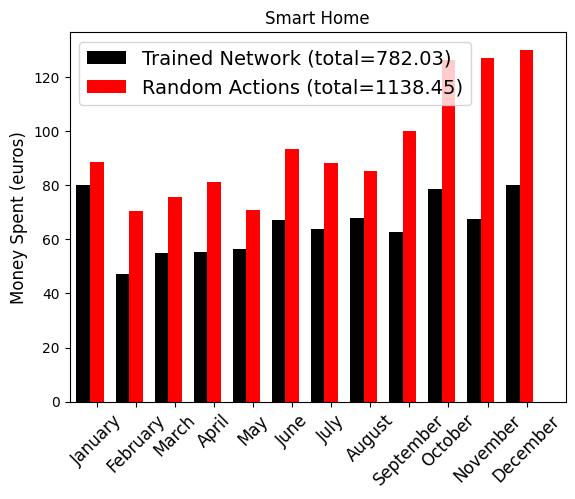

In [ ]:

histo_plotter = HistoPlotter()
monthly_total_list_ppo, _, _, _, _, _, _, _ = test_models( _get_action_ppo, network_name="trained_models/neural_network_trained.h5" )
monthly_total_list_random, _, _, _, _, _, _, _ = test_models( _get_action_random, network_name="trained_models/neural_network_trained.h5" )
histo_plotter.trained_list = monthly_total_list_ppo
histo_plotter.random_list = monthly_total_list_random
histo_plotter.plot()


#### Plot graph of battery_charge

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-82dbdf4edec6>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-4-82dbdf4edec6>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


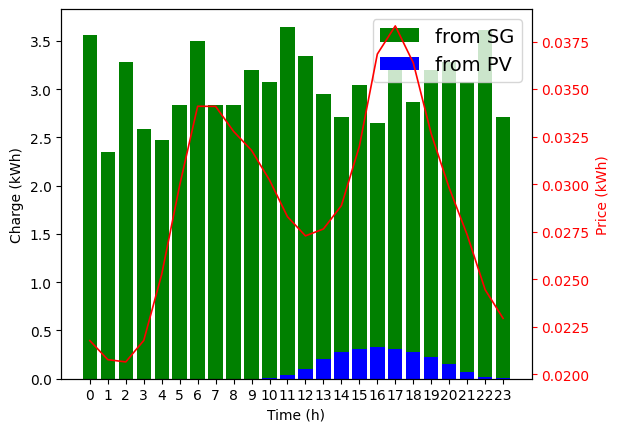

In [ ]:

_, _, hourly_home_battery__ppo, hourly_ev_battery__ppo, hourly_price_ppo, hourly_charge_ppo_sg, hourly_charge_ppo_pv, _ = test_models( _get_action_ppo, network_name="trained_models/neural_network_trained.h5" )
line_plotter = DoubleLinePlotter( hourly_home_battery__ppo, hourly_ev_battery__ppo, hourly_price_ppo, hourly_charge_ppo_sg, hourly_charge_ppo_pv )
line_plotter.plot()


#### Plot graph of reward function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: ignored

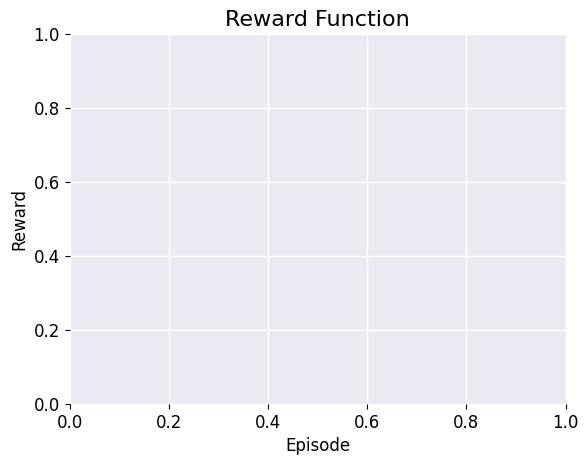

In [ ]:

plotter = LinePlotter(x_label="Episode", y_label="Reward", title="Reward Function")
plotter.load_array([ glob.glob("generated/reward_PPO_*.txt") ])
plotter.process_data( rolling_window=100, starting_pointer=0 )
plotter.render( labels=["PPO"], colors=["r"] )


#### Plot graph of consumer demands

<ipython-input-4-82dbdf4edec6>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-4-82dbdf4edec6>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


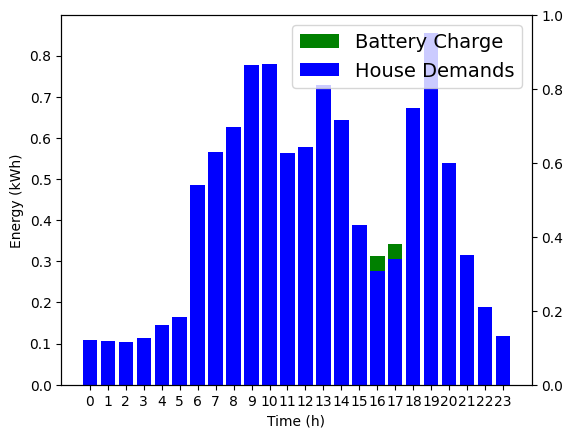

In [ ]:

_, _, hourly_home_battery__ppo, hourly_ev_battery__ppo, hourly_price_ppo, hourly_charge_ppo_sg, hourly_charge_ppo_pv, house_demands = test_models( _get_action_ppo, network_name="trained_models/neural_network_trained.h5" )

line_plotter = DemandsPlotter(house_demands, hourly_charge_ppo_pv)
line_plotter.plot()


#### Plot graph of generation

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-82dbdf4edec6>:43: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self.month = np.random.random_integers(1, 12)
<ipython-input-4-82dbdf4edec6>:44: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  self.day = np.random.random_integers(1, Constant.MONTHS_LEN[self.month-1])
<ipython-input-4-82dbdf4edec6>:45: DeprecationWarning: This function is deprecated. Please call randint(0, 23 + 1) instead
  self.time = np.random.random_integers(0, 23)


[48.73417448747644, 48.65025770585986, 48.6288384303635, 48.733024903008854, 48.78854820342278, 48.872956954773215, 48.88562823637484, 48.69371932051958, 48.41699142603683, 48.238694896135314, 47.85722719948559, 47.72644582242741, 47.739880359112945, 47.793792378645165, 47.77982020991911, 47.84844290559198, 48.06054732639065, 48.3911782877788, 48.53987138572086, 48.46923950957614, 48.164526033558644, 48.336240072881324, 48.405020920627535, 48.51493728594875]
(24,)
(24,)
(24,)


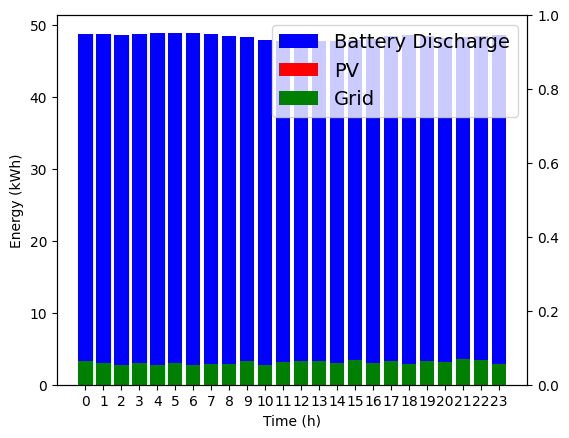

In [ ]:

_, _, hourly_home_battery__ppo, hourly_ev_battery__ppo, hourly_price_ppo, hourly_charge_ppo_sg, hourly_charge_ppo_pv, house_demands = test_models( _get_action_ppo, network_name="trained_models/neural_network_trained.h5" )

for i in range(len(hourly_home_battery__ppo)):
  hourly_home_battery__ppo[i] -= 50
print(hourly_home_battery__ppo)
print(np.array(hourly_home_battery__ppo).shape)
print(np.array(hourly_charge_ppo_pv).shape)
print(np.array(hourly_charge_ppo_sg).shape)
line_plotter = GenerationPlotter(hourly_charge_ppo_pv, hourly_charge_ppo_sg, hourly_home_battery__ppo)
line_plotter.plot()

